## Goal: Estimate asset losses for Typhoon Haiyan
1. Select Haiyan points within 600 km of the Philippines (index for storm is 1925)
2. Determine wind fields for each point.
3. Regrid wind fields onto lat-lon grid.
4. Determine maximum wind speed across wind fields.
5. Determine percent damaged across field based on vulnerability curve and max wind speed.
6. Multiply percent damaged by exposed value to determine asset losses.

## Questions/ Issues to Fix
* Add in radial velocity to wind speed
* Make sure flow direction is oriented properly
* some storms not converging properly (adjusting ckcd to find convergence...)
* Does one get same wind field regardless of what is set as radius?
* interpolate between 6-hourly points to 15 min or 30 min frequency
* What lat-lon grid should interpolate wind onto? Is 0.1x0.1 deg ok? Or should increase resolution of wind field and interpolate directly onto exposed value grid?
* Is it ok to interpolate vulnerability onto exposed value grid directly? Or should interpolate each individual wind field onto exposed value grid?

## Notes
* iir and iit are places in wind field closest to POI

In [1]:
reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#!/usr/bin/env python
from __future__ import division
from builtins import str
from builtins import range
from past.utils import old_div
import numpy as np
import datetime
import pickle
from netCDF4 import Dataset
import sys
import matplotlib.pyplot as plt
from chaz import CLE15, utility
from pygplib import readbst
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
from scipy.interpolate import griddata
from pyproj import Proj, transform
from pygplib3 import landfall as ld


In [3]:
### constant from Dan Chavas ###
fcor = 5.e-5  # [s-1] {5e-5}; Coriolis parameter at storm center
# Environmental parameters
# Outer region
# [-] {1}; 0 : Outer region Cd = constant (defined on next line); 1 : Outer region Cd = f(V) (empirical Donelan et al. 2004)
Cdvary = 1
# [-] {1.5e-3}; ignored if Cdvary = 1; surface momentum exchange (i.e. drag) coefficient
Cd = 1.5e-3
# [ms-1] {2/1000; Chavas et al 2015}; radiative-subsidence rate in the rain-free tropics above the boundary layer top
w_cool = 2./1000

# Inner region
# [-] {1}; 0 : Inner region Ck/Cd = constant (defined on next line); 1 : Inner region Ck/Cd = f(Vmax) (empirical Chavas et al. 2015)
CkCdvary = 1
# [-] {1}; ignored if CkCdvary = 1; ratio of surface exchange coefficients of enthalpy and momentum; capped at 1.9 (things get weird >=2)
CkCd = 1.

# Eye adjustment
eye_adj = 0  # [-] {1}; 0 = use ER11 profile in eye; 1 = empirical adjustment
# [-] {.15; empirical Chavas et al 2015}; V/Vm in eye is reduced by factor (r/rm)^alpha_eye; ignored if eye_adj=0
alpha_eye = .15
###

In [4]:
# LOCATION INFORMATION
cityName = 'Manila' #'Bermuda'
lat_poi = 14.5995 #32.307
lon_poi = 120.9842 #-64.7505+360.
radius = 300.  # 600 # km Haiyan is storm 660 with this radius.
er = 6371.0  # km


In [5]:
# RETRIEVE WNP STORM INFORMATION
fileName = '/data2/clee/bttracks/Allstorms.ibtracs_all.v03r10.nc'
ibtracs = readbst.read_ibtracs(fileName, 'wnp')
ipoi = np.array([1925]) # index for storm Haiyan is 1925

# Load data from file
lon = ibtracs.lon[:, ipoi]
lat = ibtracs.lat[:, ipoi]
wspd = ibtracs.wspd[:, ipoi] # wind speed in knots
days = ibtracs.days[:, ipoi] # date in days
dist2land = ibtracs.dist2land[:, ipoi]
year = ibtracs.year[ipoi]

# Derive some additional quantities from data
tt = np.empty(wspd.shape, dtype=object)
count = 0
for i in range(ipoi.shape[0]):
    for j in range(wspd.shape[0]):
        if days[j, i] == days[j, i]:
            tt[j, count] = datetime.datetime(
                1858, 11, 17, 0, 0)+datetime.timedelta(days=days[j, i])
    count += 1
lon_diff = lon[1:, :]-lon[0:-1, :]
lat_diff = lat[1:, :]-lat[0:-1, :]
londis = old_div(2*np.pi*er*np.cos(old_div(lat[1:, :],180)*np.pi),360) # 1 degree longitude in km at given latitude
dx = londis*lon_diff # longitude difference in km
dy = 110.*lat_diff # latitude difference in km
days_diff = (days[1:, :] - days[0:-1, :])*24. # days --> hours
tr = old_div(np.sqrt(dx**2+dy**2),(days_diff)) # track translation speed, km/hr
trDir = np.arctan2(lat_diff, lon_diff)
rmax = utility.knaff15(wspd, lat)*1000.  # meter
rmax[np.where(rmax<0)] = 20000 # 6-12-20: set places with radii less than 0 to 20 m to fix convergence


[10] wnp
(2071,)


/home/jbaldwin/lib/python/pygplib/readbst.py:174: RuntimeWarning: invalid value encountered in less
  lon[lon < 0] = lon[lon < 0]+360
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less


2013-11-02 06:00:00 [ 15.  15.  15.  20.  25.  30.  30.  35.  40.  45.  55.  70.  75.  90.
 110. 130. 135. 150. 155. 155. 160. 170. 170. 165. 145. 130. 120. 115.
 105. 100.  95.  90.  80.  80.  70.  60.]
0 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]


/home/jbaldwin/lib/python/chaz/CLE15.py:103: RuntimeWarning: divide by zero encountered in true_divide
  V_ER11 = (1./rr_ER11)*(Vmax*rmax + .5*fcor*rmax**2)*(old_div((2*(old_div(rr_ER11, rmax))**2),
/home/jbaldwin/lib/python/chaz/CLE15.py:104: RuntimeWarning: invalid value encountered in multiply
  (2-CkCd+CkCd*(old_div(rr_ER11, rmax))**2)))**(old_div(1, (2-CkCd))) - .5*fcor*rr_ER11
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Adjusting CkCd to find convergence
Adjusting CkCd to find convergence
Adjusting CkCd to find convergence
Adjusting CkCd to find convergence
Adjusting CkCd to find convergence
Adjusting CkCd to find convergence


/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/past/utils/__init__.py:95: RuntimeWarning: divide by zero encountered in true_divide
  return a / b


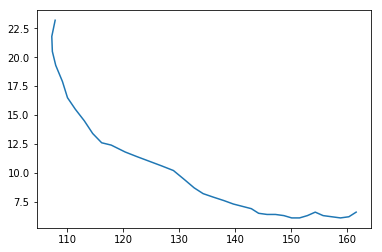

In [7]:
# CALCULATES AND COLLECTS WIND FIELDS
v_poi = []
wspd_poi = []
rmw_poi = []
wspd_poi_v2 = []
lon1 = []
lat1 = []
for iS in range(lon.shape[1]):
    iipoi = np.arange(0,36,1) #22 doesn't work with larger replacement radius of 20 km #select particular storm points to plot; previous was: utility.find_timing_Tracks(
        #lon[:, iS], lat[:, iS], wspd[:, iS], lon_poi, lat_poi, radius)
    iipoin = iipoi.size
    if iipoin > 0:
        plt.plot(lon[:, iS], lat[:, iS])
        print(tt[0, iS], wspd[iipoi, iS])
        londis = old_div(2*np.pi*er*np.cos(old_div(lat[iipoi, iS],180)*np.pi),360)
        dx = londis*(lon[iipoi, iS]-lon_poi)
        dy = 110*(lat[iipoi, iS]-lat_poi)
        distance = np.sqrt(dx*dx+dy*dy)
        distance[distance != distance] = radius+10000
        wspd_poi.append(np.nanmax(wspd[iipoi, iS]))
        lon1.append(lon[iipoi[np.argmax(wspd[iipoi, iS])], iS])
        lat1.append(lat[iipoi[np.argmax(wspd[iipoi, iS])], iS])
        rmw_poi.append(rmax[iipoi[np.argmax(wspd[iipoi, iS])], iS])
        print(iS, iipoi)
        v_temp = []
        w_temp = []
        irmax = 10000
        V = np.full([iipoin, irmax, 360],np.nan) # create empty array with storms by radii by 360 degrees
        vlon = np.full([iipoin, irmax, 360],np.nan) # create empty array with storms by radii by 360 degrees
        vlat = np.full([iipoin, irmax, 360],np.nan) # create empty array with storms by radii by 360 degrees
        iir = np.zeros([iipoin],dtype=int) # create empty array of locations of wind field closest to POI
        iit = np.zeros([iipoin],dtype=int) # create empty array of locations of wind field closest to POI
        for ii in iipoi:
            iin = ii-np.min(iipoi) # count on scale starting with 0
            if not np.isnan(tr[ii, iS]):
                wspd_az = wspd[ii, iS]/1.94384449 - tr[ii, iS]*0.278*0.7  # km/hr--> m/s, plus assuming 70% of translation speed is flow at surface (correction from Chia-Ying's script where factor was 0.7)
            else:
                wspd_az = wspd[ii, iS]/1.94384449

            # need to use ms-1
            rr, VV, r0, rmerge, Vmerge = CLE15.ER11E04_nondim_rmaxinput(wspd_az,
                                                                        rmax[ii,
                                                                             iS], fcor, Cdvary,
                                                                        Cd, w_cool, CkCdvary, CkCd, eye_adj, alpha_eye)
            # stop at 300Km
            ir = np.argwhere(rr <= (radius+50)*1000.)[-1, 0]
            V[iin,:ir,:] = np.reshape(np.repeat(VV[:ir], 360), [ir,360]) # take wind profile and tile it onto 360 degrees
            angle = np.arange(0., 360., 1.)/180.*np.pi+0.5*np.pi-trDir[ii, iS] # define angle relative to track direction 
            rFactor = utility.translationspeedFactor(old_div(rr[:ir],rmax[ii, iS]))
            vt = np.array([tr[ii, iS]*np.cos(angle[id]) for id in range(360)]) # tangential wind
            V[ii-np.min(iipoi),:ir,:] = V[ii-np.min(iipoi),:ir,:]+np.array([rFactor[iir]*vt for iir in range(ir)])
            londis = np.abs(old_div(2*np.pi*er*np.cos(lat[ii, iS]/180.*np.pi),360)) # distance of 1 deg longitude at storm latitude
            theta, rr1 = np.meshgrid(np.arange(0., 360., 1.), rr[:ir]/1000.) # make mesh grid (360 deg x radii) of values of angle and radius in wind field
            dlon = old_div(rr1*np.cos(theta/180.*np.pi),111) # translate distance along radius in direction to deg longitude
            dlat = old_div(rr1*np.sin(theta/180.*np.pi),londis) # translate distance along radius in direction to deg latitude
            vlon[iin,:ir,:] = lon[ii, iS]+dlon # longitude of each wind field point
            vlat[iin,:ir,:] = lat[ii, iS]+dlat # latitude of each wind field point
            dummy = np.sqrt(((vlon[iin,:ir,:]-lon_poi)*londis)**2+((vlat[iin,:ir,:]-lat_poi)*111)**2) # distance between wind field grid points and POI
            iir[iin], iit[iin] = np.argwhere(dummy == dummy.min()).flatten() # find place in wind field closest to POI
            v_temp.append(V[iin, iir[iin], iit[iin]]*1.94384449) # 1.94384 --> convert m/s to knots
            w_temp.append(np.nanmax(V[iin,:ir,:])*1.94384449) # 1.94384 --> convert m/s to knots
            # v_poi = griddata((vlon.flatten(),vlat.flatten()),V.flatten(),(lon_poi,lat_poi)
        v_poi.append(np.nanmax(np.array(v_temp)))
        wspd_poi_v2.append(
            np.nanmax([np.nanmax(np.array(w_temp)), np.nanmax(wspd[iipoi, iS])]))
    else:
        v_poi.append(float('nan'))
        wspd_poi.append(float('nan'))
        rmw_poi.append(float('nan'))
        wspd_poi_v2.append(float('nan'))
        lon1.append(float('nan'))
        lat1.append(float('nan'))

In [8]:
# FUNCTION TO REGRID WIND FIELDS

inProj = Proj(init='epsg:4326') #https://epsg.io/4326
outProj = Proj(init='epsg:3395') #https://epsg.io/3395, world map in meters

# DEFINE GRID TO PUT EVERYTHING ON
X = np.arange(-180,180.1,0.1)
Y = np.arange(-80,80.1,0.1)
X1, Y1 = np.meshgrid(X,Y)
X2,Y2 = transform(inProj,outProj,X1,Y1)

def regrid_rect(lon,lat,V):
    x1,y1 = lon,lat
    x2,y2 = transform(inProj,outProj,x1,y1)
    x2 = x2.flatten()
    x2 = x2[~np.isnan(x2)]
    y2 = y2.flatten()
    y2 = y2[~np.isnan(y2)]
    v2 = V.flatten()
    v2 = v2[~np.isnan(v2)]
    v3 = griddata((x2, y2), v2, (X2, Y2), method='linear')
    return v3


In [9]:
%%time
# REGRID EACH WIND FIELD

n = np.shape(V)[0]
a = np.empty((n,np.shape(X1)[0],np.shape(Y1)[1]))
a[:] = np.nan
for i in range(n):
    a[i,...] = regrid_rect(vlon[i,...],vlat[i,...],V[i,...])
    

CPU times: user 11min 38s, sys: 26.6 s, total: 12min 4s
Wall time: 7min 55s


/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: All-NaN slice encountered
  


Text(0.5, 1.0, 'Typhoon Haiyan')

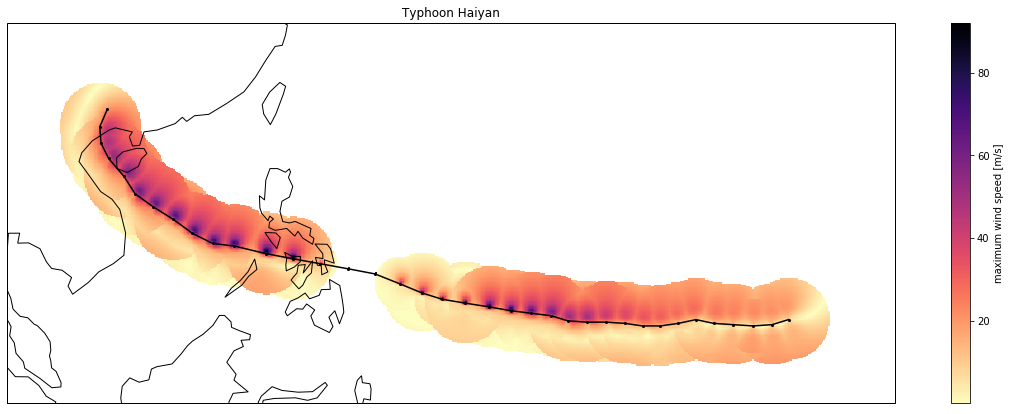

In [148]:
# PLOT MAX WIND SPEED OF ONE STORM
maxspeed = np.nanmax(np.abs(a),axis=0)

plt.figure(figsize=(20, 7))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
plt.pcolormesh(X1,Y1,maxspeed,cmap=plt.cm.magma_r)
plt.plot(np.array(lon),np.array(lat),marker = 'o',markersize=2,color='k')
plt.ylim((0,30))
plt.xlim((100,170))
cbar = plt.colorbar()
cbar.set_label('maximum wind speed [m/s]', rotation=90)
ax.coastlines()
plt.title('Typhoon Haiyan')


Text(0.5, 1.0, 'b) track speed = 9 m/s')

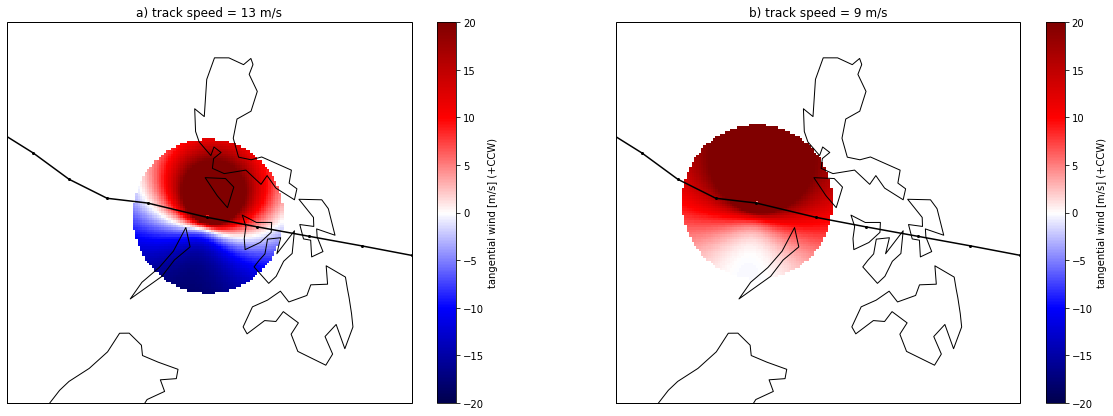

In [166]:
# Determine structure and max at edges
# maximum on southern portion has to do with translation speed factor being smaller as move farther out from radius of maximum wind

plt.figure(figsize=(20, 7))

ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
n = 25
speed = a[n,...]
plt.pcolormesh(X1,Y1,speed,cmap=plt.cm.seismic)
plt.plot(np.array(lon),np.array(lat),marker = 'o',markersize=2,color='k')
plt.ylim((4,20))
plt.xlim((112,129))
cbar = plt.colorbar()
plt.clim(-20, 20)
cbar.set_label('tangential wind [m/s] (+CCW)', rotation=90)
ax1.coastlines()
plt.title('a) track speed = 13 m/s')

ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
n = 26
speed = a[n,...]
plt.pcolormesh(X1,Y1,speed,cmap=plt.cm.seismic)
plt.plot(np.array(lon),np.array(lat),marker = 'o',markersize=2,color='k')
plt.ylim((4,20))
plt.xlim((112,129))
cbar = plt.colorbar()
plt.clim(-20, 20)
cbar.set_label('tangential wind [m/s] (+CCW)', rotation=90)
ax2.coastlines()
plt.title('b) track speed = 9 m/s')


In [160]:
# EMANUEL VULNERABILITY CURVES

# Vthresh = windspeed at and below which no damage occurs
Vthresh = 25.7 # 50 kts / 1.944 kts per m/s

# Vhalf = windspeed at which half the property value is lost
Vhalf1 = 56.6 # 110 kts /1.944 kts per m/s
Vhalf2 = 77.2 # 150 kts / 1.944 kts per m/s

def vulnerability(V):
    vn = np.nanmax(np.array([V-Vthresh,np.zeros(np.shape(V))]),axis=0)/(Vhalf1-Vthresh)
    # f = fraction of property value lost
    f = vn**3/(1+vn**3)
    return f


Text(0.5, 1.0, 'Typhoon Haiyan')

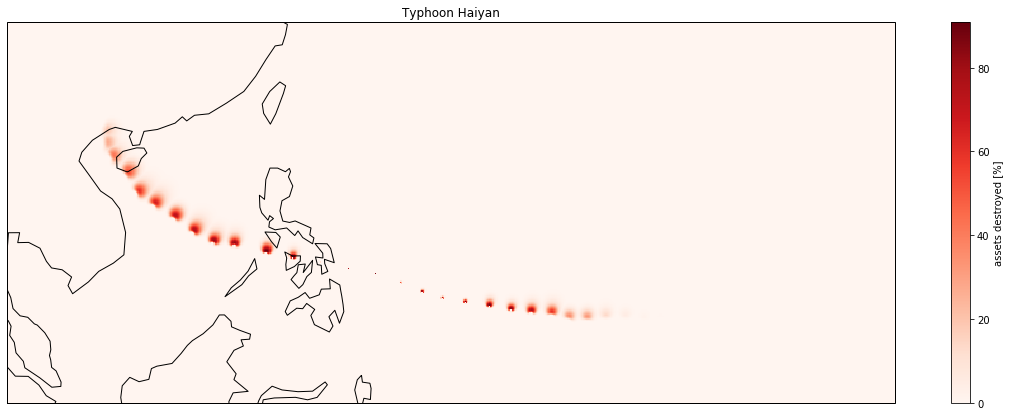

In [163]:
maxgustspeed = maxspeed*1.25 # from info that Chia-Ying sent-- 1.2-1.3 seems to be the factor range between 1-min sustained and peak gust speed
destroyed = vulnerability(maxspeed)*100

plt.figure(figsize=(20, 7))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
plt.pcolormesh(X1,Y1,destroyed,cmap=plt.cm.Reds)
plt.ylim((0,30))
plt.xlim((100,170))
cbar = plt.colorbar()
cbar.set_label('assets destroyed [%]', rotation=90)
ax.coastlines()
plt.title('Typhoon Haiyan')

In [48]:
# INTERPOLATE VULNERABILITY DATA ONTO EXPOSED VALUE GRID
ev = xr.open_dataset('/home/jbaldwin/WorldBank/EXPOSED_VALUE/asia_exposed_value.nc')


In [50]:
ev.lat[1:10]



<xarray.DataArray 'lat' (lat: 9)>
array([0.012084, 0.020417, 0.02875 , 0.037084, 0.045417, 0.05375 , 0.062084,
       0.070417, 0.07875 ])
Coordinates:
  * lat      (lat) float64 0.01208 0.02042 0.02875 ... 0.06208 0.07042 0.07875